In [1]:
import sys  
sys.path.insert(0, '../Libraries/') 

In [3]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


# Weather data
* Source: https://www.visualcrossing.com/ Fee for uploading more than 100 lines of info. Please contact me with your needs, I will happily pay for your data
* Units: Wind is km/h, Temperature Celsius, Solar Radiation W/m^2


In [4]:

weather = pd.read_excel("Climate/EssexJct-05012020-10312020.xlsx",header=0,date_parser=[5],)

In [5]:
weather.columns

Index(['Name', 'Wind Direction', 'Latitude', 'Cloud Cover',
       'Minimum Temperature', 'Date time', 'Precipitation', 'Solar Radiation',
       'Dew Point', 'Relative Humidity', 'ID', 'Precipitation Cover',
       'Longitude', 'Info', 'Temperature', 'Maximum Temperature', 'Visibility',
       'Wind Speed', 'Solar Energy', 'Heat Index', 'Weather Type',
       'Snow Depth', 'Sea Level Pressure', 'Snow', 'Name.1', 'Wind Gust',
       'Conditions', 'Wind Chill'],
      dtype='object')

In [9]:
weather = weather.set_index('Date time')

<AxesSubplot:xlabel='Date time'>

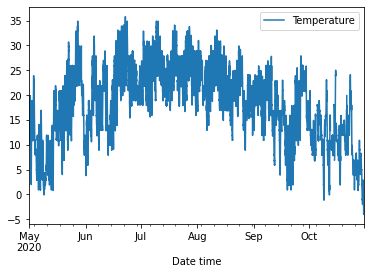

In [10]:
weather.plot(y="Temperature")